In [134]:
import os
from bids.layout import BIDSLayout
from nilearn import plotting
import matplotlib.pyplot as plt
import numpy as np
from nilearn.masking import compute_epi_mask
from nilearn.image import mean_img, resample_to_img
from nilearn import plotting, masking
from nilearn.image import math_img
import nibabel as nib
from nilearn import datasets, plotting
from nilearn.image import math_img, load_img
import matplotlib.pyplot as plt
from nilearn.glm.thresholding import threshold_stats_img
from datetime import datetime
import nibabel as nib
from nilearn import surface
from nilearn.plotting import plot_surf_stat_map
from matplotlib.ticker import ScalarFormatter
from nibabel import freesurfer

ds_path = '/Users/jonathantsay/GestureContextPilot/CodeForExp/JT_Semantomotor/data/bids'

# Initialize the BIDS layout and include the derivatives in it
layout = BIDSLayout(ds_path, derivatives = True)
layout.add_derivatives(os.path.join(ds_path, "results", "first-level"))

save_path = "/Users/jonathantsay/GestureContextPilot/CodeForExp/JT_Semantomotor/figures"  # Change this to your desired path

# Get today's date and convert it to a string in the format YYYYMMDD
today_str = datetime.today().strftime('%Y%m%d')
# today_str = '20231026'

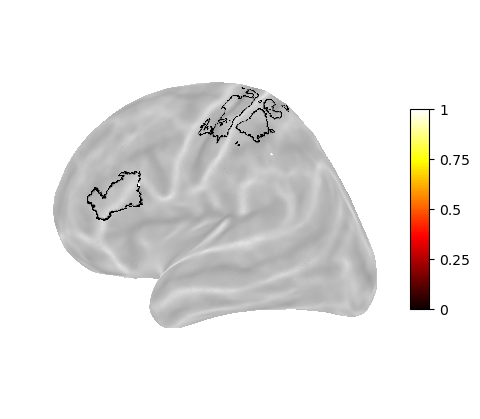

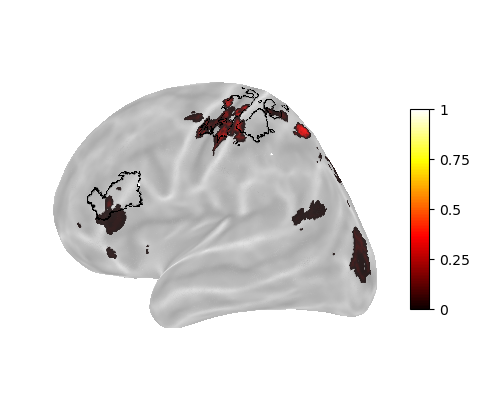

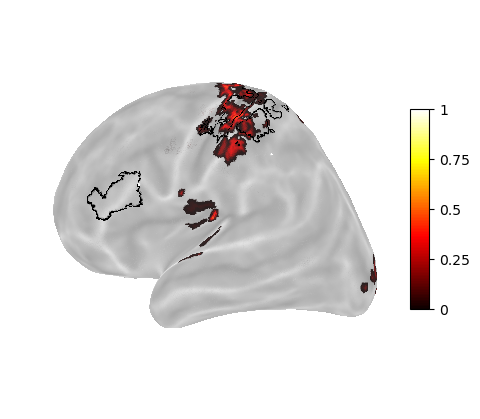

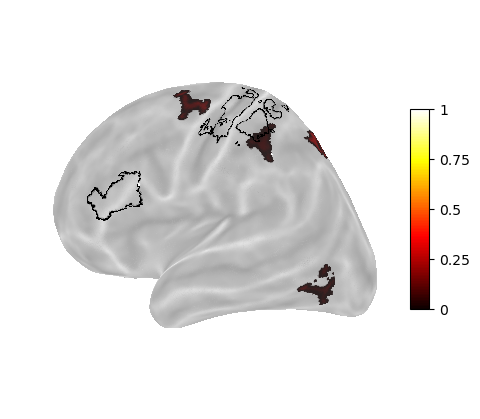

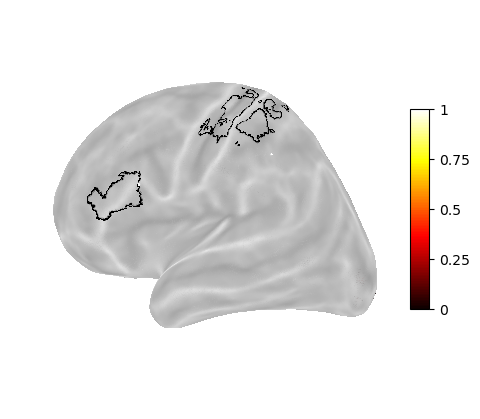

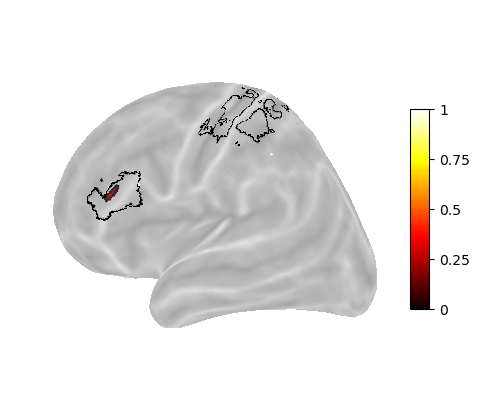

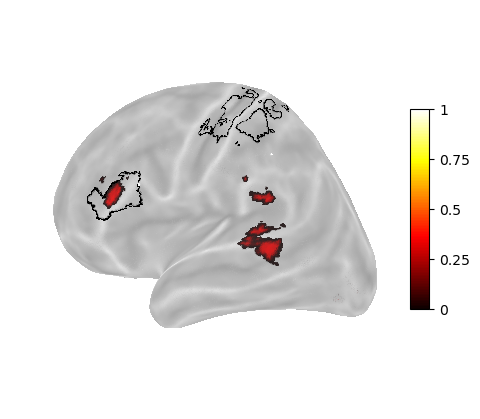

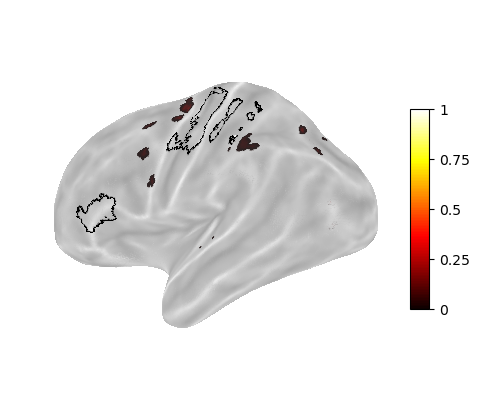

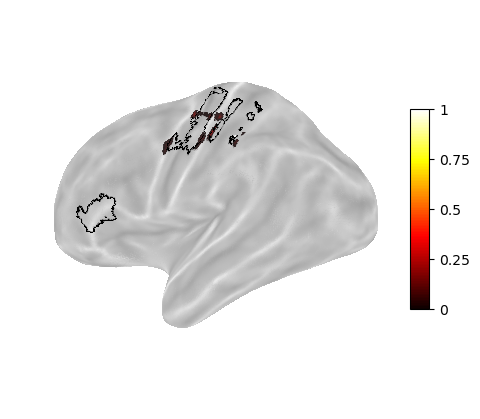

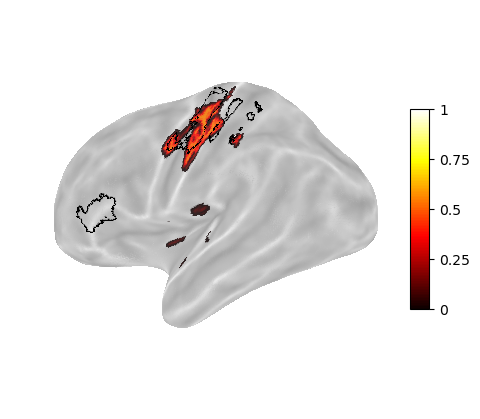

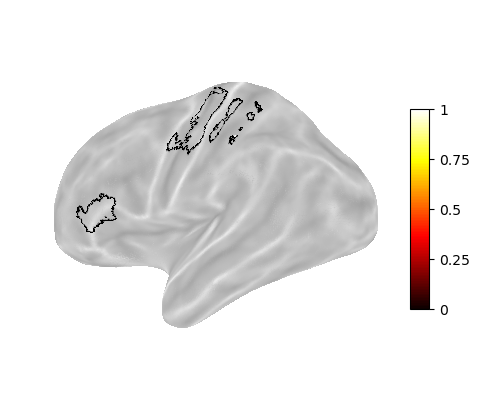

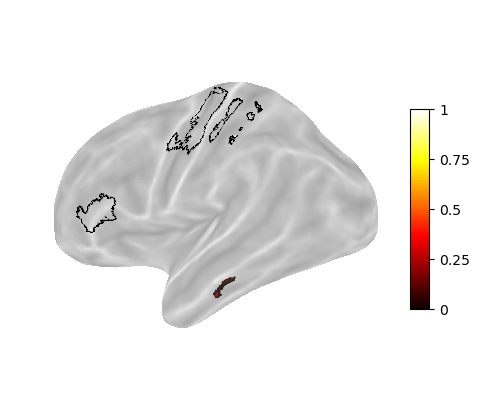

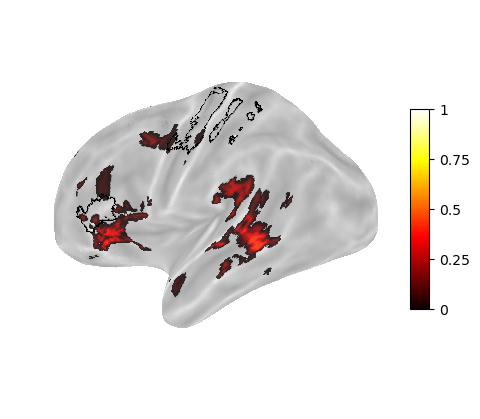

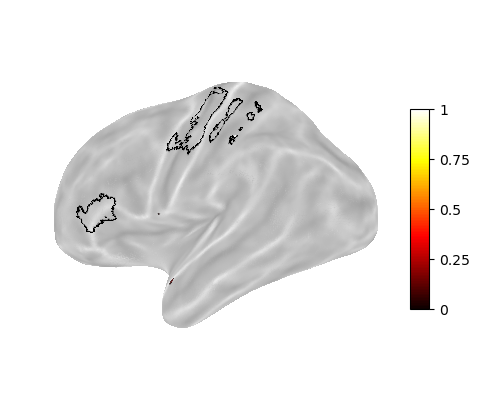

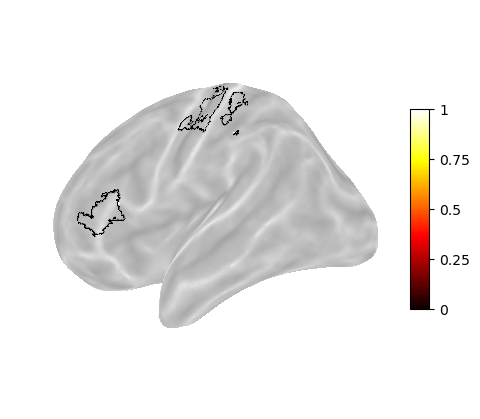

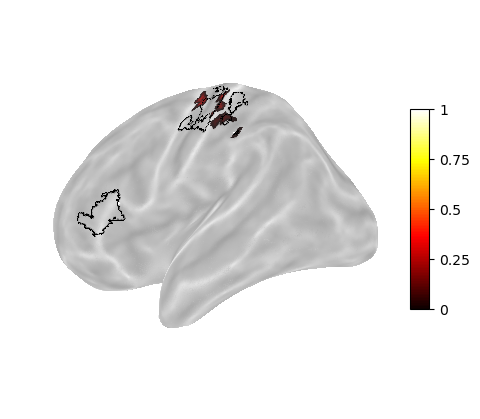

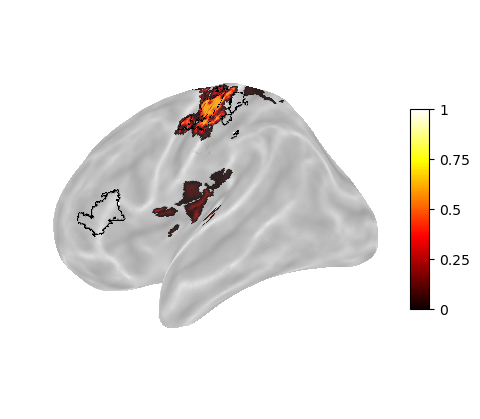

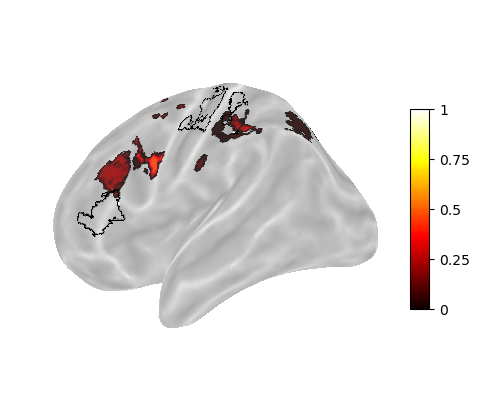

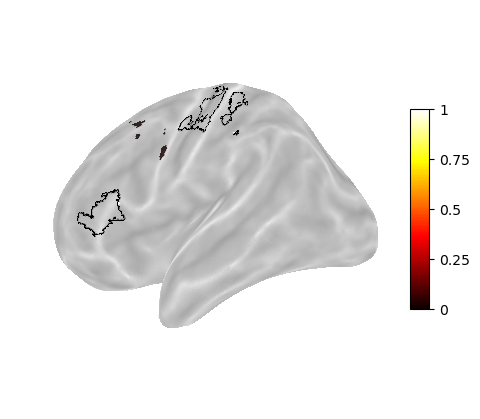

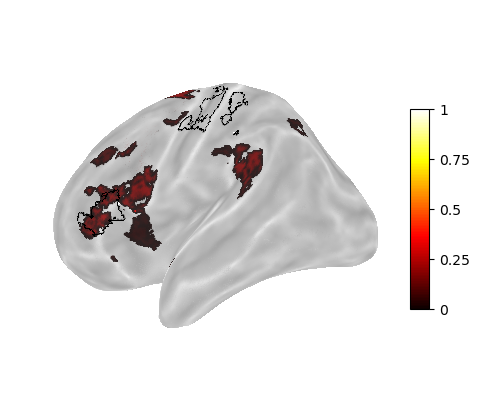

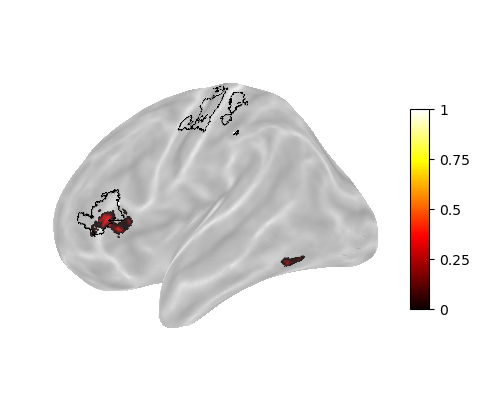

In [73]:
# Define your contrast list
contrast_list = ['palm', 'peace', 'fist','letter', 'number', 'action', 'abstract']

subjects = ['01', '02', '04']

#contrast_list = ['fist']

view = 'lateral'

for s_idx, subject in enumerate(subjects):
    # Load the pial surface in Gifti format
    lh_pial_file = f'/Users/jonathantsay/GestureContextPilot/CodeForExp/JT_Semantomotor/data/bids/derivatives/fmriprep/sub-{subject}/anat/sub-{subject}_acq-mprage_hemi-L_pial.surf.gii'
    lh_pial_gii = nib.load(lh_pial_file)
    lh_pial_coords = lh_pial_gii.darrays[0].data
    lh_pial_faces = lh_pial_gii.darrays[1].data
    lh_pial_mesh = (lh_pial_coords, lh_pial_faces)
    
    # Load the inflated surface in Gifti format
    lh_inflated_file = f'/Users/jonathantsay/GestureContextPilot/CodeForExp/JT_Semantomotor/data/bids/derivatives/fmriprep/sub-{subject}/anat/sub-{subject}_acq-mprage_hemi-L_inflated.surf.gii'
    lh_inflated_gii = nib.load(lh_inflated_file)
    lh_inflated_coords = lh_inflated_gii.darrays[0].data
    lh_inflated_faces = lh_inflated_gii.darrays[1].data
    lh_inflated_mesh = (lh_inflated_coords, lh_inflated_faces)

    # Define the path to the subject’s curvature file
    lh_bg_file = f'/Users/jonathantsay/GestureContextPilot/CodeForExp/JT_Semantomotor/data/bids/derivatives/fmriprep/sourcedata/freesurfer/sub-{subject}/surf/lh.avg_curv'
    lh_bg_data = nib.freesurfer.read_morph_data(lh_bg_file)

    # Load label file, and find S1 and M1
    label_file = f'/Users/jonathantsay/GestureContextPilot/CodeForExp/JT_Semantomotor/data/bids/derivatives/fmriprep/sourcedata/freesurfer/sub-{subject}/label/lh.BA_exvivo.thresh.annot'
    label_data = surface.load_surf_data(label_file)
    label_data = np.array(label_data)

    # primary S1
    #index_s1 = np.isin(label_data, [1, 2, 3, 4])
    # primary M1
    #index_m1 = np.isin(label_data, [5, 6])
    # primary Broca
    index_b = np.isin(label_data, [9])

    # Assign 1 to elements in the mask, and 0 to elements outside the mask
    #label_data[index_s1 | index_m1] = 1
    label_data[index_b] = 2
    label_data[~(index_b)] = 0

    #mask_path = f'/Users/jonathantsay/GestureContextPilot/CodeForExp/JT_Semantomotor/data/bids/results/transformed-masks/sub-{subject}/sub-{subject}_transformed_avital_handmask.nii.gz'
    #mask_img = nib.load(mask_path)
    #mask_data = mask_img.get_fdata()
    #mask_texture = surface.vol_to_surf(mask_img, lh_pial_mesh, interpolation = 'linear', radius = 1)
    #mask_texture[mask_texture > 0.9] = 1
    #mask_texture[mask_texture <= 0.9] = 0
    
    # saving here incase you want to use for Joern's mask
    mask_path = f'/Users/jonathantsay/GestureContextPilot/CodeForExp/JT_Semantomotor/data/bids/results/transformed-masks/sub-{subject}/sub-{subject}_transformed_joern_handmask.nii.gz'
    mask_img = nib.load(mask_path)
    mask_id = 1
    mask_data = mask_img.get_fdata()
    mask_data[(mask_data > mask_id) | (mask_data < mask_id)] = 0
    mask_data[mask_data == mask_id] = 1 
    mask_img_mod = nib.Nifti1Image(mask_data, affine = mask_img.affine, header= mask_img.header)
    mask_texture = surface.vol_to_surf(mask_img_mod, lh_pial_mesh, interpolation = 'linear', radius = 1)
    mask_texture[mask_texture > 0.5] = 1
    mask_texture[mask_texture <= 0.5] = 0
    
    mask_comb = np.maximum(mask_texture, label_data)

    for c_idx, contrast in enumerate(contrast_list):
        stat_files = layout.get(
            subject=subject,
            desc=contrast,
            suffix='score',
            extension='.nii.gz',
            return_type='filename'
        )

        # Using a list comprehension to keep only those strings that do not contain 'run'
        filtered_list = [s for s in stat_files if 'other' in s and 'cluster' in s]

        for f_idx, stat_map in enumerate(filtered_list):
            # Load statistical map
            stat_map_img = nib.load(stat_map)

            # Project the statistical map onto the pial surface
            lh_texture = surface.vol_to_surf(stat_map_img, lh_pial_mesh, interpolation = 'linear', radius = 1)

            #lh_texture = np.round(lh_texture * 10) / 10
            
            if len( np.unique(lh_texture) ) == 1:
                lh_texture[0] = .00001
            
            # Plot the statistical map on the inflated surface with curvature background
            figure = plotting.plot_surf_stat_map(
                lh_inflated_mesh,
                lh_texture,
                view = 'lateral',
                hemi= 'left',
                colorbar=True,
                threshold=0.00001,
                bg_map=lh_bg_data,
                bg_on_data=True,
                alpha=0.5,
                darkness=0.5,
                vmax=1,
                symmetric_cbar=False,
                title_fontsize='x-large',
                colorbar_fontsize='large',
                colorbar_height=0.6,
                colorbar_tick_length=0.1,
            )


            plotting.plot_surf_contours(
                lh_inflated_mesh,
                roi_map = mask_comb,
                colors=['w', 'black', 'black'],
                figure=figure,
            )
            

            # Save the figure
            filename = os.path.join(save_path, f"sub-{subject}_contrast-{contrast}_view-{view}_{today_str}.jpeg")
            #plt.savefig(filename, format='jpeg', dpi=300)
            
            # Show the plots
            plt.show()
            


In [61]:
# save broca area 45 into mask 

atlas = datasets.fetch_atlas_juelich("maxprob-thr0-2mm")
atlas_img = atlas.maps

#print(atlas.labels)
my_index = atlas.labels.index("GM Broca's area BA45") # "GM Broca's area BA45" GM Premotor cortex BA6 'GM Visual cortex V1 BA17' BA17 # Broca's 44 incredible

# # Create a mask for the Fourth Ventricle
my_mask = math_img('a == {}'.format(my_index), a=atlas_img)

# Find the middle of the brain along the x-axis (assumes RAS orientation)
x_dim = my_mask.shape[0]
middle_x = x_dim // 2  # Using // ensures an integer result

# Nullify the right hemisphere (assumes neurological convention)
my_mask = math_img("img * (np.arange(img.shape[0]) < {})[:, None, None]".format(middle_x), img=my_mask)
mask_data = my_mask.get_fdata()

# Specify the directory where you want to save the NIfTI file
output_directory = '/Users/jonathantsay/GestureContextPilot/CodeForExp/JT_Semantomotor/masks/HarvardAtlas'

# Create the directory if it does not exist
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Specify the full path to the output NIfTI file
output_filepath = os.path.join(output_directory, 'my_ba45_harvard_mask.nii.gz')

# Save the NIfTI image
nib.save(my_mask, output_filepath)
print("Mask saved to:", output_filepath)



Mask saved to: /Users/jonathantsay/GestureContextPilot/CodeForExp/JT_Semantomotor/masks/HarvardAtlas/my_ba45_harvard_mask.nii.gz


In [138]:
# List of subject IDs
sID = ['01', '02', '04']

# List of contrasts
contrast_list = np.array(['palm', 'peace', 'fist', 'letter', 'number', 'action', 'abstract'])

# Masks
masks = ['s1', 'ba45']

# Initialize the DataFrame to store the data
data = pd.DataFrame()

# Loop over subjects
for s_idx, subject in enumerate(sID):
    # Loop over masks
    for mask in masks:
        # Load the subject-specific mask image
        if mask == 's1':
            mask_path = f'/Users/jonathantsay/GestureContextPilot/CodeForExp/JT_Semantomotor/data/bids/results/transformed-masks/sub-{subject}/sub-{subject}_transformed_joern_handmask.nii.gz'
            mask_img = nib.load(mask_path)
            mask_data = mask_img.get_fdata()
            mask_id = 1
            mask_data[(mask_data > mask_id) | (mask_data < mask_id)] = 0
            mask_data[mask_data == mask_id] = 1 
            mask_img_mod = nib.Nifti1Image(mask_data, affine = mask_img.affine, header= mask_img.header)
        elif mask == 'ba45':
            mask_path = f'/Users/jonathantsay/GestureContextPilot/CodeForExp/JT_Semantomotor/data/bids/results/transformed-masks/sub-{subject}/sub-{subject}_transformed_ba45_harvard_handmask.nii.gz'
            mask_img_mod = nib.load(mask_path)
            
        # Loop over contrasts
        for i, contrast in enumerate(contrast_list):
            # Get the filenames for the current subject and contrast
            filenames = layout.get(subject=subject, desc=contrast, suffix='score', extension='.nii.gz', return_type='filename')
            
            # Filter out filenames containing 'run' or 'other'
            filtered_list = [s for s in filenames if 'run' not in s and 'rest' in s and 'threshed' not in s]
            #print(filtered_list)
        
            # Check if any filenames were found
            if filtered_list:
                # Load the statistical image
                stat_img = nib.load(filtered_list[0])
                
                # Resample the mask image to match the statistical image
                resampled_mask_img = resample_to_img(mask_img_mod, stat_img, interpolation='nearest')
                
                # Apply the mask to the statistical image
                masked_data = masking.apply_mask(stat_img, resampled_mask_img)
                
                # Add the masked data to the DataFrame
                temp_df = pd.DataFrame(masked_data).transpose()
                temp_df['Mean_Activity'] = temp_df.mean(axis=1)
                temp_df['SN'] = subject
                temp_df['Cond'] = contrast
                temp_df['Mask'] = mask  # Add a column to indicate which mask was used
                data = pd.concat([data, temp_df], ignore_index=True)
            else:
                print(f"No filenames found for contrast {contrast}. Skipping.")

data['Cond'][data['Cond'] == 'peace'] = 'v-sign' 
data['Cond'][data['Cond'] == 'abstract'] = 'abs' 
data['Cond'][data['Cond'] == 'action'] = 'act' 
data['Cond'][data['Cond'] == 'number'] = 'num' 
data['Cond'][data['Cond'] == 'letter'] = 'let' 

/var/folders/qf/gprldtv546n8mtt3q8_9_rmm0000gn/T/ipykernel_62570/2840123810.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Cond'][data['Cond'] == 'peace'] = 'v-sign'
/var/folders/qf/gprldtv546n8mtt3q8_9_rmm0000gn/T/ipykernel_62570/2840123810.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Cond'][data['Cond'] == 'abstract'] = 'abs'
/var/folders/qf/gprldtv546n8mtt3q8_9_rmm0000gn/T/ipykernel_62570/2840123810.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

/Users/jonathantsay/anaconda3/envs/WeatherModel/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/var/folders/qf/gprldtv546n8mtt3q8_9_rmm0000gn/T/ipykernel_62570/2129047531.py:61: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


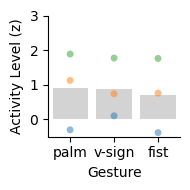

In [137]:
# plot univariate

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

mymaskname = 's1'

# Filter data
filtered_data = data[(data['Cond'] == 'fist') | (data['Cond'] == 'v-sign') | (data['Cond'] == 'palm')]
filtered_data = filtered_data[filtered_data['Mask'] == mymaskname]

# Assume that 'condition' is a column in 'sub_df'; sort by this column if desired
custom_order = ['palm', 'v-sign', 'fist']

# Define your custom order here, if needed
filtered_data['Cond'] = pd.Categorical(filtered_data['Cond'], categories=custom_order, ordered=True)

# Sorting, resetting index, grouping by 'SN' and 'semantic_condition', and calculating the mean
filtered_data_mean = (
    filtered_data
    .sort_values(by=['SN', 'Cond'])
    .groupby(['SN', 'Cond'], observed=True)  # Set observed=True to avoid the FutureWarning
    .agg({'Mean_Activity': 'mean'})  # Explicitly define which columns to aggregate
    .reset_index()  # to move 'SN' and 'semantic_condition' back to columns
)

# Creating a bar graph using catplot
g = sns.catplot(
    data=filtered_data_mean, 
    x='Cond', y='Mean_Activity',
    kind='bar',
    color='lightgrey',
    errorbar=None, height=2, aspect=1,
    legend=False  # remove the legend
)

# Adding individual data points using stripplot
sns.stripplot(
    data=filtered_data_mean,
    x='Cond', y='Mean_Activity',
    hue = 'SN',
    jitter=False,  # add some jitter for better visualization
    alpha= 0.5,  # make points semi-transparent to see overlapping points
    ax=g.axes[0,0],  # plot on the same axis
    legend=False,
    dodge=False,  # to align points with bars
)

if mymaskname == 's1':
    ylim_range = [-0.5, 7]
else:
    ylim_range = [-0.5, 3]

# Additional formatting, if needed
g.set_axis_labels('Gesture', 'Activity Level (z)')
g.despine(top=True, right=True)
#Setting y-axis limits
g.set(ylim=(ylim_range[0], ylim_range[1]))

plt.tight_layout()

filename = f"{save_path}/my_univariate_{mymaskname}_action_{today_str}.jpeg"
plt.savefig(filename, format='jpeg', dpi=300)

plt.show()


/var/folders/qf/gprldtv546n8mtt3q8_9_rmm0000gn/T/ipykernel_62570/3276116474.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Cond'] = pd.Categorical(filtered_data['Cond'], categories=custom_order, ordered=True)
/Users/jonathantsay/anaconda3/envs/WeatherModel/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/var/folders/qf/gprldtv546n8mtt3q8_9_rmm0000gn/T/ipykernel_62570/3276116474.py:60: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


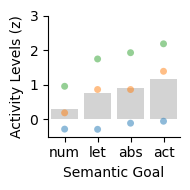

In [142]:
# Name of the mask to exclude
mymaskname = 'ba45'

# Filter data
filtered_data = data[
    ((data['Cond'] == 'let') | 
     (data['Cond'] == 'num') | 
     (data['Cond'] == 'act') | 
     (data['Cond'] == 'abs')) & 
    (data['Mask'] == mymaskname)  # Exclude rows with the specified mask
]

# Assume that 'condition' is a column in 'sub_df'; sort by this column if desired
custom_order = ['num', 'let',  'abs', 'act']

# Define your custom order and set it on the DataFrame
filtered_data['Cond'] = pd.Categorical(filtered_data['Cond'], categories=custom_order, ordered=True)

# Sorting, resetting index, grouping by 'SN' and 'semantic_condition', and calculating the mean
filtered_data_mean = (
    filtered_data
    .sort_values(by=['SN', 'Cond'])
    .groupby(['SN', 'Cond'], observed=True)  # Added observed=True here
    .agg({'Mean_Activity': 'mean'})
    .reset_index()
)

# Creating a bar graph using catplot
g = sns.catplot(
    data=filtered_data_mean, 
    x='Cond', y='Mean_Activity',
    kind='bar',
    color='lightgrey',
    errorbar=None, height=2, aspect=1,
    legend=False  # remove the legend
)

# Adding individual data points using stripplot
sns.stripplot(
    data=filtered_data_mean,
    x='Cond', y='Mean_Activity',
    hue = 'SN',
    jitter=False,  # add some jitter for better visualization
    alpha= 0.5,  # make points semi-transparent to see overlapping points
    ax=g.axes[0,0],  # plot on the same axis
    legend=False,
    dodge=False,  # to align points with bars
)

if mymaskname == 's1':
    ylim_range = [-0.5, 7]
else:
    ylim_range = [-0.5, 3]
    
# Additional formatting, if needed
g.set_axis_labels('Semantic Goal', 'Activity Levels (z)')
g.despine(top=True, right=True)

g.set(ylim=(ylim_range[0], ylim_range[1]))
plt.tight_layout()

filename = f"{save_path}/my_univariate_semantic_{mymaskname}_{today_str}.jpeg"
plt.savefig(filename, format='jpeg', dpi=300)

plt.show()
